<a href="https://colab.research.google.com/github/peksikeksi/airfoil-cfd-dim-reduction/blob/master/airfoil_cfd_data_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata

In [ ]:
# Install Kaggle API
!pip install -q kaggle

# Set up Kaggle credentials
!mkdir -p ~/.kaggle  # Create the hidden directory if it doesn't exist
!cp kaggle.json ~/.kaggle/  # Copy kaggle.json to the hidden directory
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions for your user only

!kaggle datasets download -d udvasbasak/ae646-gp1-data

!unzip -q '/content/ae646-gp1-data.zip' -d '/content/dataset/'

Dataset URL: https://www.kaggle.com/datasets/udvasbasak/ae646-gp1-data
License(s): CC0-1.0
 90% 95.0M/105M [00:01<00:00, 97.1MB/s]
100% 105M/105M [00:01<00:00, 75.2MB/s] 


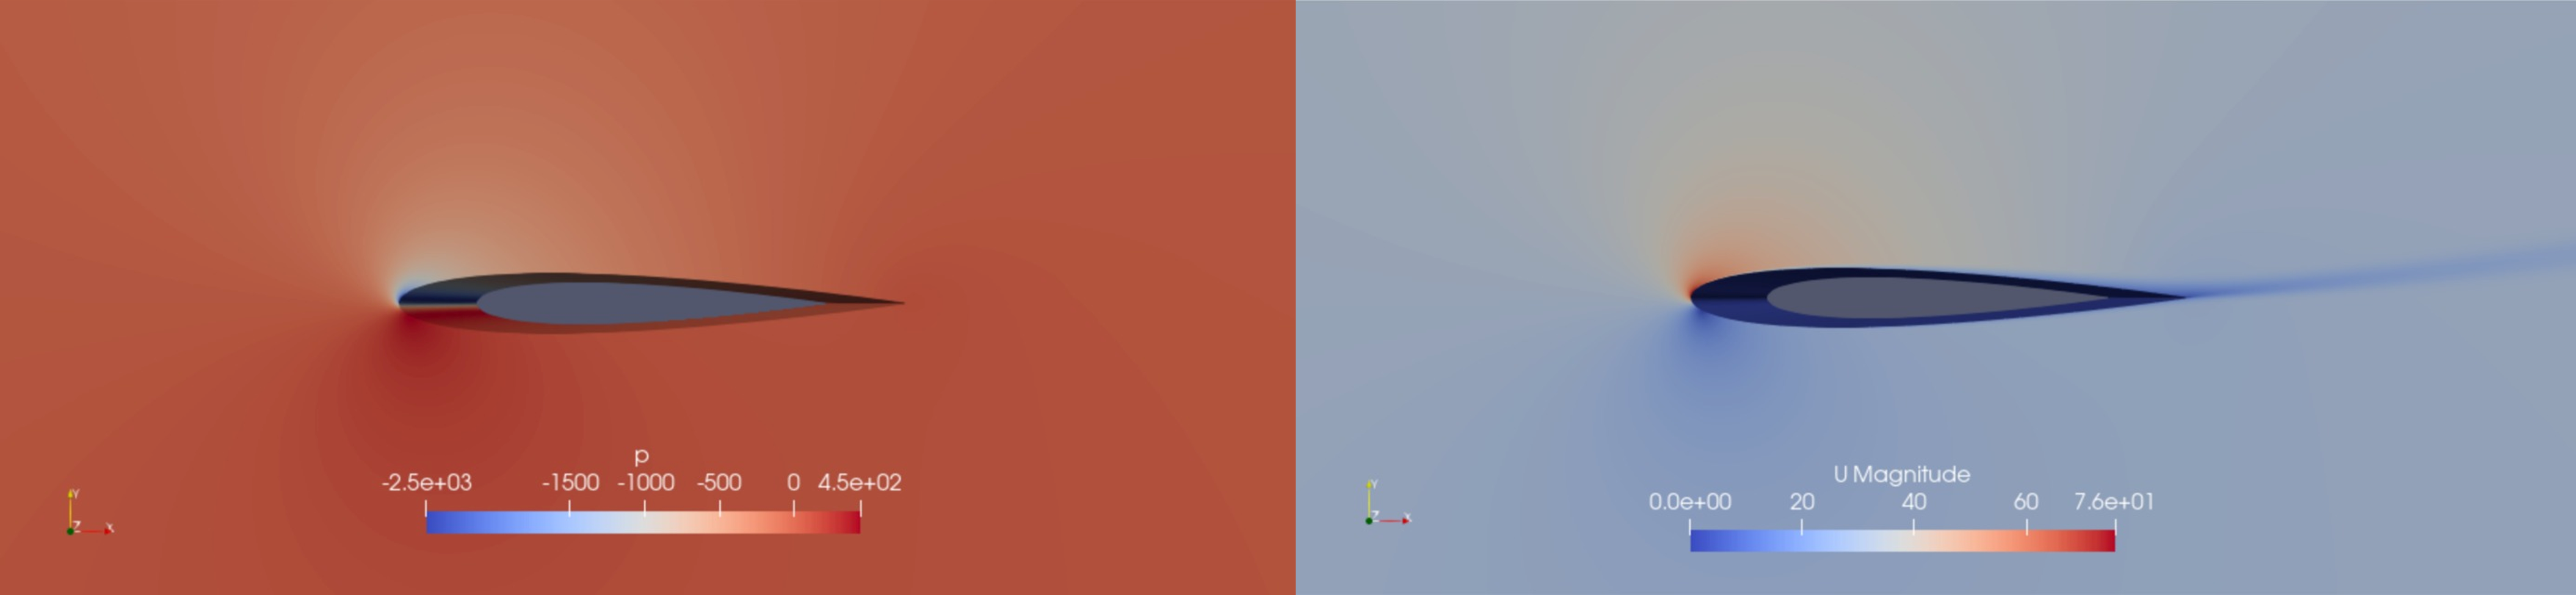

In [ ]:
naca_0012_image = cv2.imread('/content/dataset/0012.png', cv2.IMREAD_UNCHANGED)

if naca_0012_image is not None:
    cv2_imshow(naca_0012_image)
else:
    print("Error: Could not read the image file.")

In [ ]:
naca0012_df = pd.read_csv('/content/dataset/0012.csv')
naca0012_df.head()

,p,U:0,U:1,U:2,Points:0,Points:1,Points:2
0,-1728.4,0.000000,0.0000,0.000000e+00,8.172900e-09,0.00015,0
1,-1728.4,0.056763,5.6287,2.750300e-20,-3.795000e-06,0.00015,0
2,-1679.5,0.000000,0.0000,0.000000e+00,9.763100e-09,-0.00015,0
3,-1679.5,-0.053615,5.5703,-1.525600e-21,-3.793400e-06,-0.00015,0
4,-1728.4,0.112460,11.1340,-1.450200e-20,-7.716700e-06,0.00015,0


In [ ]:
class FlowFieldVisualizer:
    """
    A class for visualizing steady airfoil flow fields.

    Attributes:
        data (DataFrame): The input data containing flow field information.
        filtered_data (DataFrame): Filtered data based on specified range of coordinates.
        fig (Figure): The matplotlib figure object.
        axs (Axes): The matplotlib axes object.

    Methods:
        filter_data(x_range, y_range): Filters the input data based on specified range of coordinates.
        plot_scatter(ax, x_data, y_data, c_data, cmap_label): Plots scatter plot with color mapping.
        visualize(): Visualizes velocity components and pressure against position coordinates.
        generate_streamlines(x_range, y_range, num_streamlines=15, streamline_density=1.5):
            Generates streamlines of the flow field within specified range of coordinates.
    """
    def __init__(self, data):
        """
        Initializes the FieldVisualizer object.

        Args:
            data (DataFrame): Input data containing flow field information.
        """
        self.data = data
        self.filtered_data = None
        self.fig = None
        self.axs = None

    def filter_data(self, x_range, y_range):
        """
        Filters the input data based on specified range of coordinates.

        Args:
            x_range (tuple): Range of x coordinates.
            y_range (tuple): Range of y coordinates.

        Raises:
            ValueError: If required columns are not found in the input data or filtered data is empty.
        """
        if not all(col in self.data.columns for col in ['Points:0', 'Points:1', 'U:0', 'U:1', 'U:2', 'p']):
            raise ValueError("Required columns not found in data.")
        self.filtered_data = self.data[
            (self.data['Points:0'] >= x_range[0]) &
            (self.data['Points:0'] <= x_range[1]) &
            (self.data['Points:1'] >= y_range[0]) &
            (self.data['Points:1'] <= y_range[1])
        ]
        if self.filtered_data.empty:
            raise ValueError("Filtered data is empty.")

    def plot_scatter(self, ax, x_data, y_data, c_data, cmap_label):
        """
        Plots scatter plot with color mapping.

        Args:
            ax (Axes): Matplotlib axes object.
            x_data (array-like): x-coordinate data.
            y_data (array-like): y-coordinate data.
            c_data (array-like): Data to be mapped to colors.
            cmap_label (str): Label for the color map.

        Returns:
            None
        """
        scatter = ax.scatter(x_data, y_data, c=c_data, cmap='inferno', marker='o', s=5)
        cbar = self.fig.colorbar(scatter, ax=ax, label=cmap_label)

    def visualize(self):
        """
        Visualizes velocity components and pressure against position coordinates.

        Raises:
            ValueError: If data is not filtered. Call filter_data() first.
        """
        if self.filtered_data is None:
            raise ValueError("Data not filtered. Call filter_data() first.")
        self.fig, self.axs = plt.subplots(2, 2, figsize=(12, 10))

        x_data = self.filtered_data['Points:0']
        y_data = self.filtered_data['Points:1']

        self.plot_scatter(self.axs[0, 0], x_data, y_data, self.filtered_data['U:0'], 'U0')
        self.plot_scatter(self.axs[0, 1], x_data, y_data, self.filtered_data['U:1'], 'U1')
        self.plot_scatter(self.axs[1, 0], x_data, y_data, self.filtered_data['U:2'], 'U2')
        self.plot_scatter(self.axs[1, 1], x_data, y_data, self.filtered_data['p'], 'Pressure')

        titles = ['Velocity Component U0 vs Position (Point 0, Point 1)',
                  'Velocity Component U1 vs Position (Point 0, Point 1)',
                  'Velocity Component U2 vs Position (Point 0, Point 1)',
                  'Pressure vs Position (Point 0, Point 1)']

        for i in range(2):
            for j in range(2):
                self.axs[i, j].set_xlabel('Point 0')
                self.axs[i, j].set_ylabel('Point 1')
                self.axs[i, j].set_title(titles[i * 2 + j])

        plt.tight_layout()
        plt.show()

    def generate_streamlines(self, x_range, y_range, num_streamlines=15, streamline_density=1.5):
        """
        Generates streamlines of the flow field within specified range of coordinates.

        Args:
            x_range (tuple): Range of x coordinates.
            y_range (tuple): Range of y coordinates.
            num_streamlines (int, optional): Number of streamlines to generate.
            streamline_density (float, optional): Density of streamlines.

        Raises:
            ValueError: If data is not filtered. Call filter_data() first.
        """
        if self.filtered_data is None:
            raise ValueError("Data not filtered. Call filter_data() first.")
        x = self.filtered_data['Points:0']
        y = self.filtered_data['Points:1']
        u = self.filtered_data['U:0']
        v = self.filtered_data['U:1']

        xi = np.linspace(x_range[0], x_range[1], 100)
        yi = np.linspace(y_range[0], y_range[1], 100)
        xi, yi = np.meshgrid(xi, yi)

        ui = griddata((x, y), u, (xi, yi), method='linear')
        vi = griddata((x, y), v, (xi, yi), method='linear')

        plt.figure(figsize=(10, 6))
        plt.streamplot(xi, yi, ui, vi, color='k', density=streamline_density, linewidth=1, )
        plt.scatter(x, y, color='tab:red', s=1)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Flow Field Streamlines')
        plt.xlim(x_range)
        plt.ylim(y_range)
        plt.grid()
        plt.show()

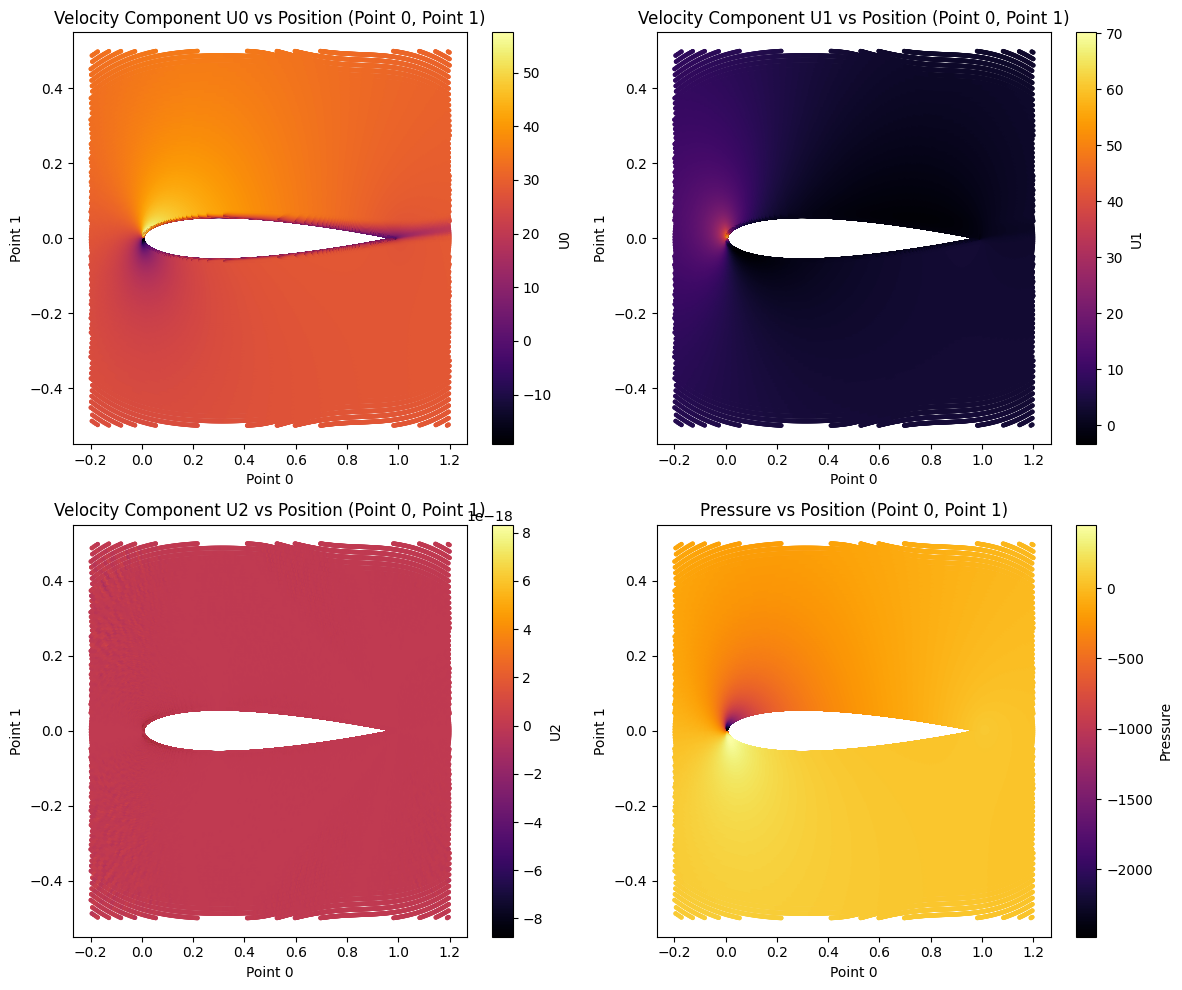

In [ ]:
# Define the range of x and y coordinates for filtering the data
x_range = (-0.2, 1.2)
y_range = (-0.5, 0.5)

# Filter raw data and visualize
flow_field_raw_view = FlowFieldVisualizer(naca0012_df)
flow_field_raw_view.filter_data(x_range=x_range, y_range=y_range)
flow_field_raw_view.visualize()

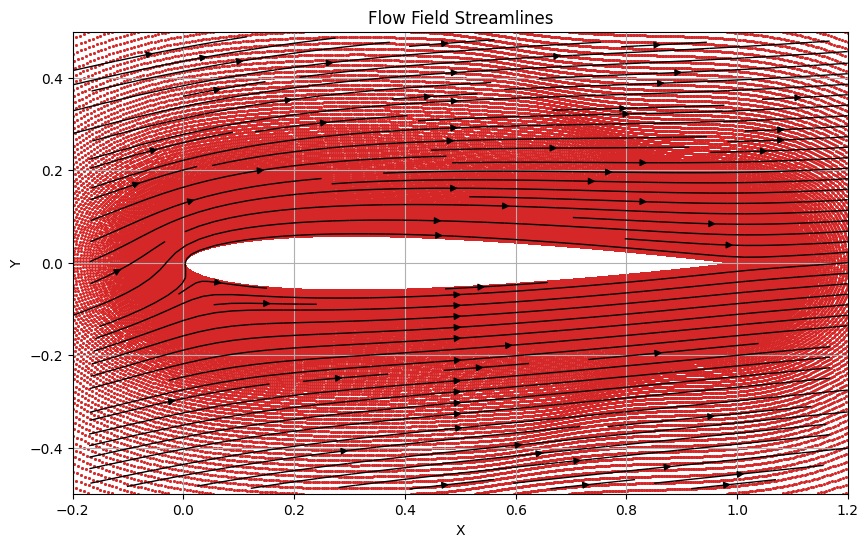

In [ ]:
# Generate streamlines for the filtered flow field data
flow_field_raw_view.generate_streamlines(x_range=x_range, y_range=y_range)

In [ ]:
# Select relevant values - namely pressure and velocity
# Transform the DataFrame into a numpy array
naca0012 = naca0012_df.values
naca0012_wp = naca0012_df[['p', 'U:0', 'U:1', 'U:2']].values


# Rescale the data
sc = StandardScaler()
naca0012_sc = sc.fit_transform(naca0012_wp)

### SVD

In [ ]:
# Compute economy SVD for rescaled data
# U_hat: Left singular vectors, S_hat: Singular values, V_hat: Right singular vectors
U_hat, S_hat, V_hat = np.linalg.svd(naca0012_sc, full_matrices=False)

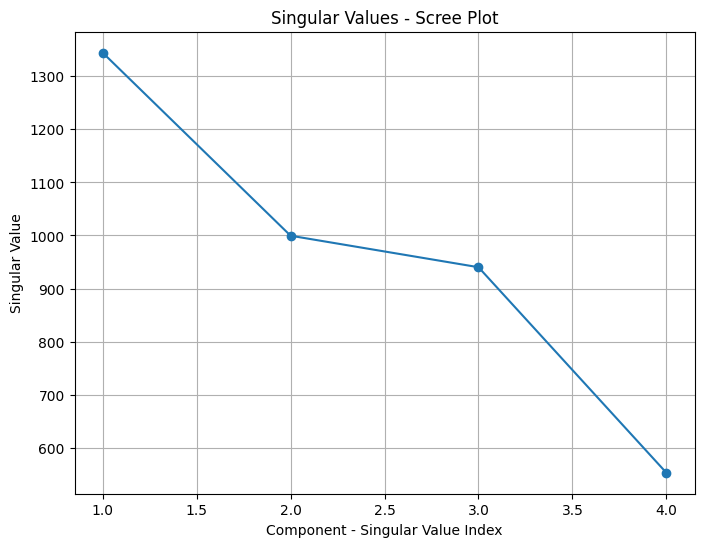

In [ ]:
# Plot singular values
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(S_hat) + 1), S_hat, marker='o', linestyle='-')
plt.xlabel('Component - Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Singular Values - Scree Plot')
plt.grid(True)
plt.show()

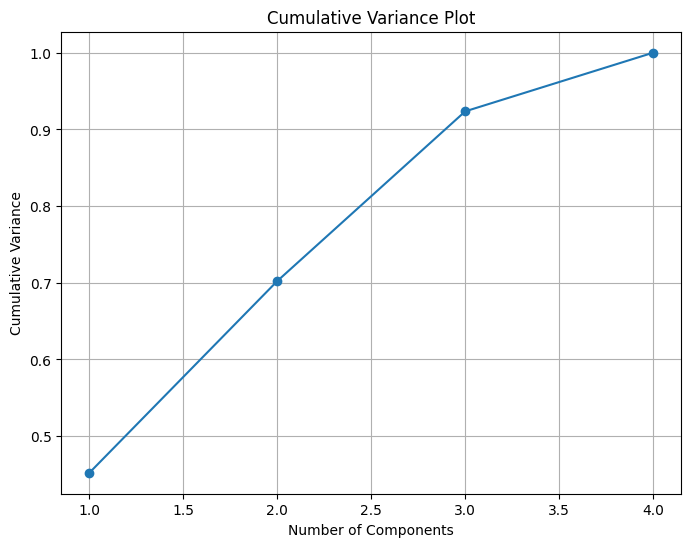

In [ ]:
# Compute cumulative variance
cumulative_variance = np.cumsum(S_hat**2) / np.sum(S_hat**2)

# Plot cumulative variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance Plot')
plt.grid(True)
plt.show()

In [ ]:
# Select components
# In this case we will choose r = 3
r = 3

# Reconstruct the data using selected components and inverse transform to original scale
svd_recon_naca0012_wp = U_hat[:, :r] @ np.diag(S_hat[:r]) @ V_hat[:r, :]
svd_recon_naca0012_wp = sc.inverse_transform(svd_recon_naca0012_wp)

points = naca0012[:, 4:]
svd_recon_naca0012 = np.concatenate((svd_recon_naca0012_wp, points), axis=1)
column_names = ['p', 'U:0', 'U:1', 'U:2', 'Points:0', 'Points:1', 'Points:2']
svd_recon_naca0012_df = pd.DataFrame(svd_recon_naca0012, columns=column_names)

In [ ]:
svd_recon_naca0012_df.head()

,p,U:0,U:1,U:2,Points:0,Points:1,Points:2
0,-651.008979,9.235295,23.850439,3.306057e-21,8.172900e-09,0.00015,0.0
1,-762.253717,8.338478,27.016490,3.046769e-20,-3.795000e-06,0.00015,0.0
2,-627.897527,9.014238,23.279553,3.226922e-21,9.763100e-09,-0.00015,0.0
3,-737.461784,8.021448,26.424405,1.365116e-21,-3.793400e-06,-0.00015,0.0
4,-870.912698,7.462761,30.116383,-1.187073e-20,-7.716700e-06,0.00015,0.0


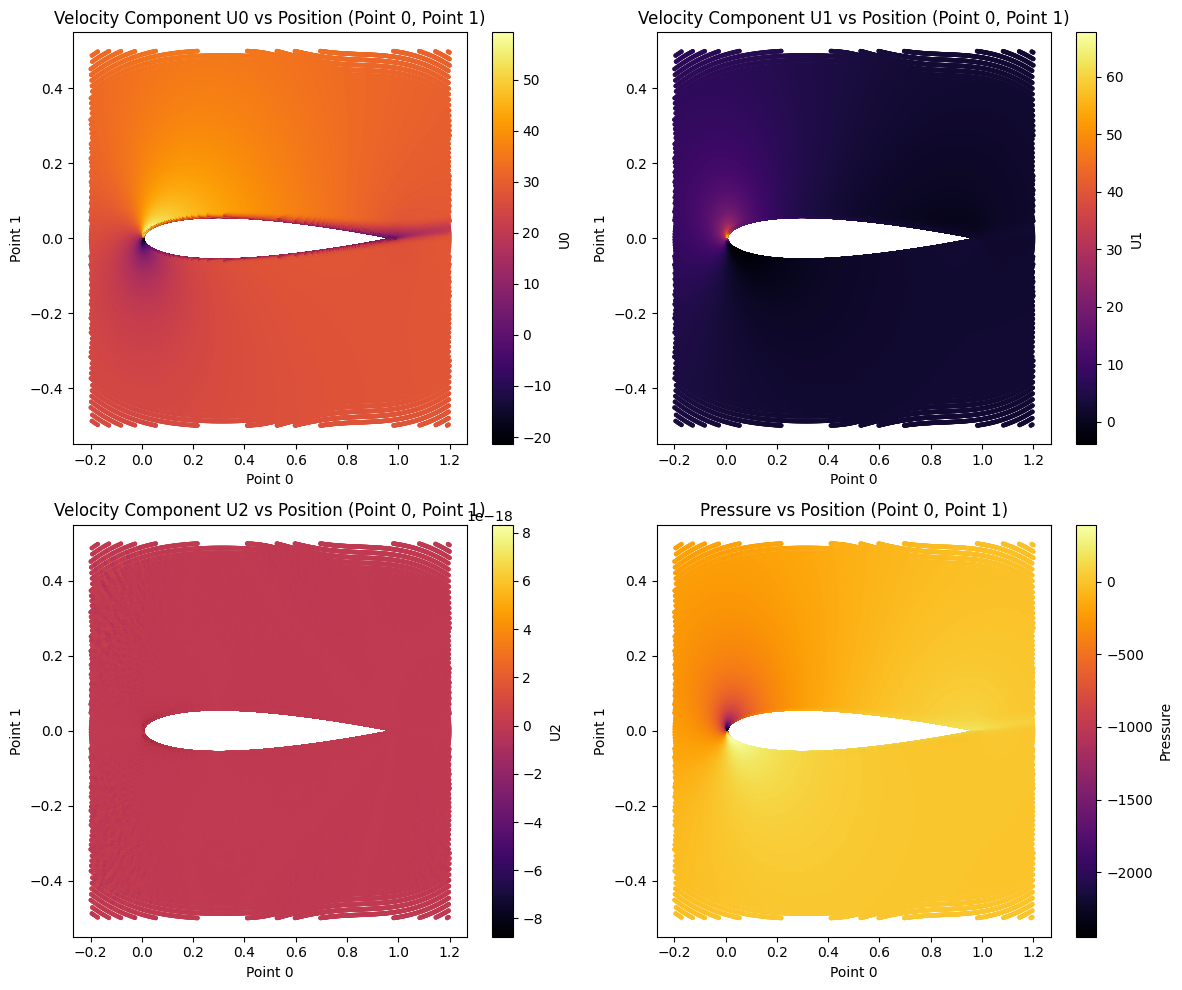

In [ ]:
# Filter raw data and visualize
flow_field_svd_view = FlowFieldVisualizer(svd_recon_naca0012_df)
flow_field_svd_view.filter_data(x_range=x_range, y_range=y_range)
flow_field_svd_view.visualize()

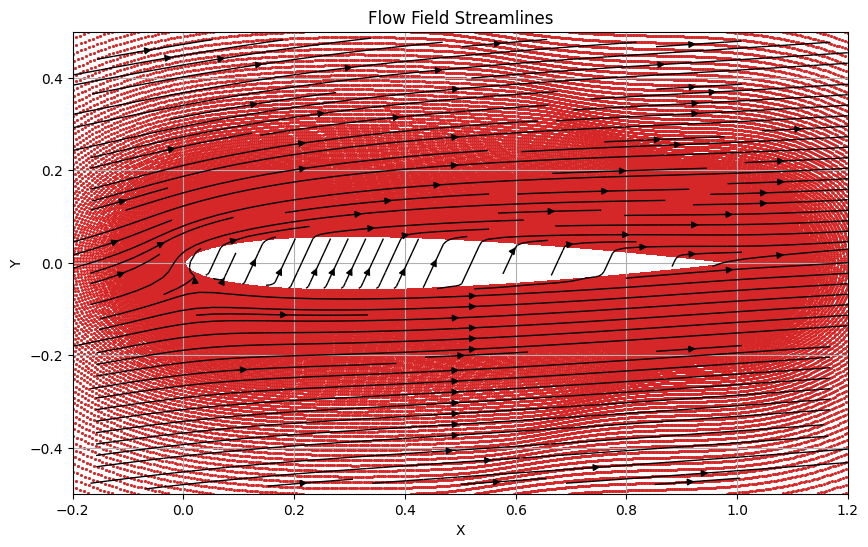

In [ ]:
# Generate streamlines for the reconstructed filtered flow field data
flow_field_svd_view.generate_streamlines(x_range=x_range, y_range=y_range)

In [ ]:
# Compute RMSE for each variable
rmse_values = []
for col in column_names:
    rmse = mean_squared_error(svd_recon_naca0012_df[col], naca0012_df[col], squared=False)
    rmse_values.append(rmse)

# Print RMSE values
for col, rmse in zip(column_names, rmse_values):
    print(f'RMSE for {col}: {rmse}')

RMSE for p: 120.55388871897954
RMSE for U:0: 1.033376611944054
RMSE for U:1: 2.668727638142171
RMSE for U:2: 3.6992881057528416e-22
RMSE for Points:0: 0.0
RMSE for Points:1: 0.0
RMSE for Points:2: 0.0


### POD

In [ ]:
# Compute the covariance matrix
covariance_matrix = np.cov(naca0012_sc, rowvar=False)

# Calculate eigenvalues and eigenvectors in descending order
eigen_vals, eigen_vects = np.linalg.eigh(covariance_matrix)

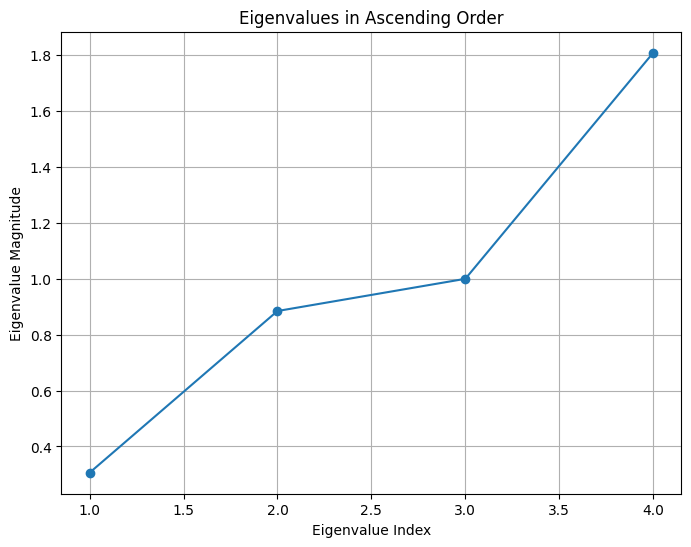

In [ ]:
# Plot the eigenvalues using a scatter plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigen_vals) + 1), eigen_vals, marker='o')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude')
plt.title('Eigenvalues in Ascending Order')
plt.grid(True)
plt.show()

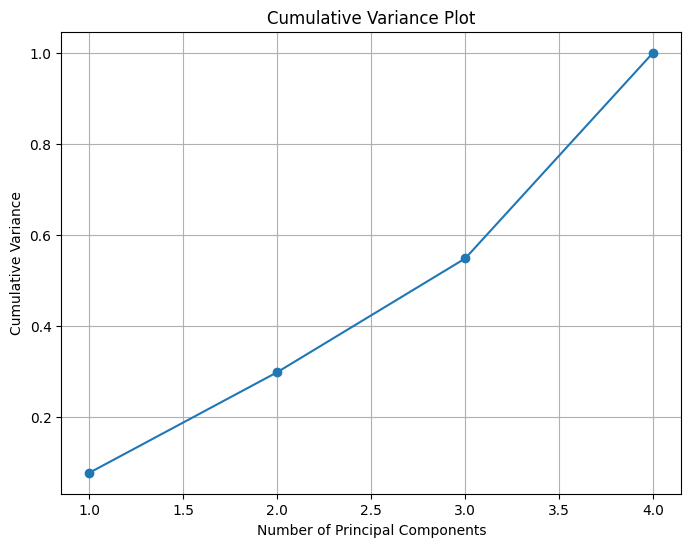

In [ ]:
# Compute cumulative variance
cumulative_variance = np.cumsum(eigen_vals) / np.sum(eigen_vals)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance Plot')
plt.grid(True)
plt.show()

In [ ]:
# Choose the number of principal components (r)
r = 4
selected_eig_vects = eigen_vects[:, :r]

# Project the scaled data onto the selected principal components
projected_data = np.dot(naca0012_sc, selected_eig_vects)

# Perform inverse transformation for reconstruction
reconstructed_data = np.dot(projected_data, selected_eig_vects.T)
reconstructed_data = sc.inverse_transform(reconstructed_data)

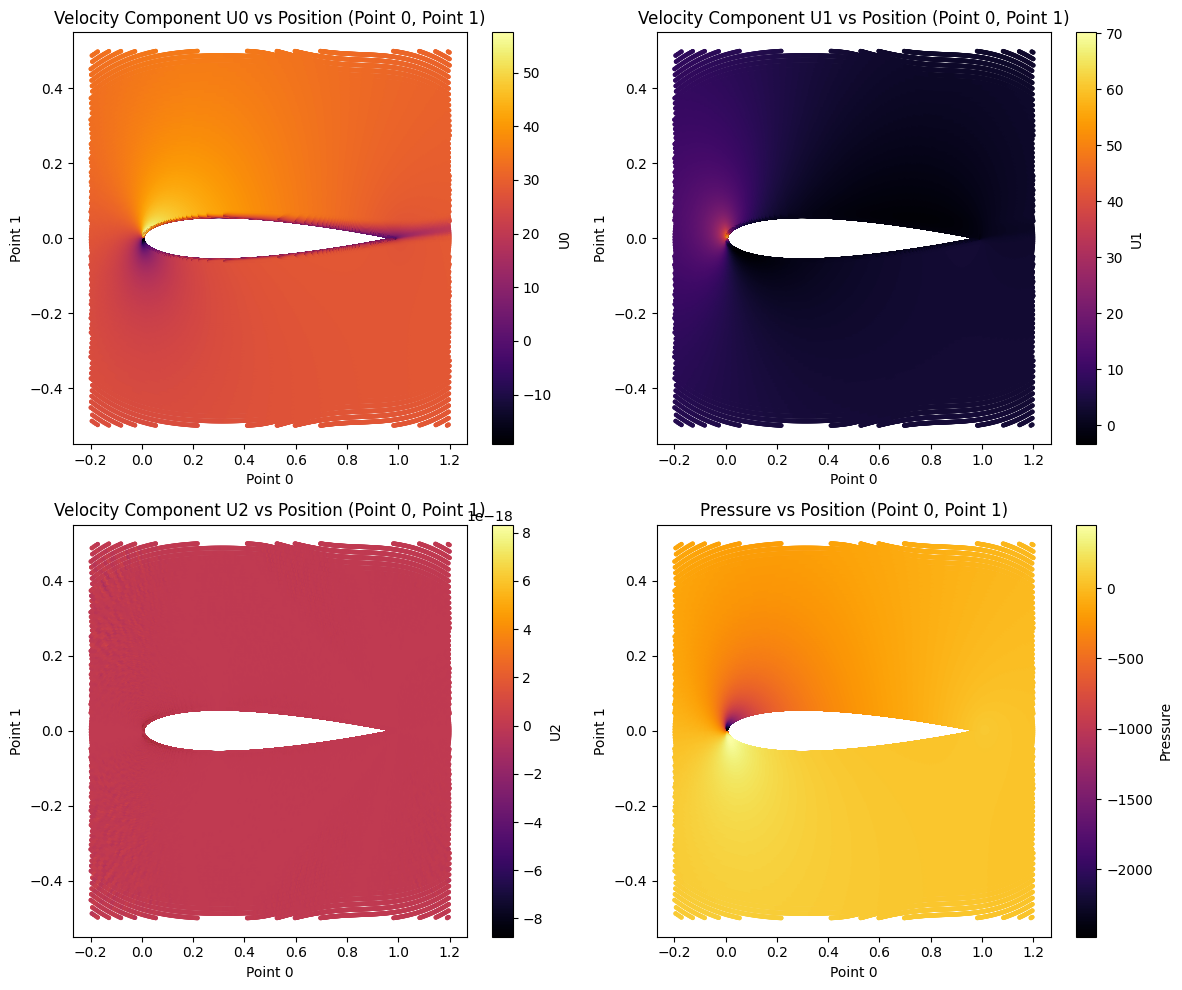

In [ ]:
pod_recon_naca0012 = np.concatenate((reconstructed_data, points), axis=1)  # We have defined points before
columns = ['p', 'U:0', 'U:1', 'U:2', 'Points:0', 'Points:1', 'Points:2']
pod_recon_naca0012_df = pd.DataFrame(pod_recon_naca0012, columns=columns)

flow_field_pod_view = FlowFieldVisualizer(pod_recon_naca0012_df)
flow_field_pod_view.filter_data(x_range=x_range, y_range=y_range) # Same ranges as before
flow_field_pod_view.visualize()

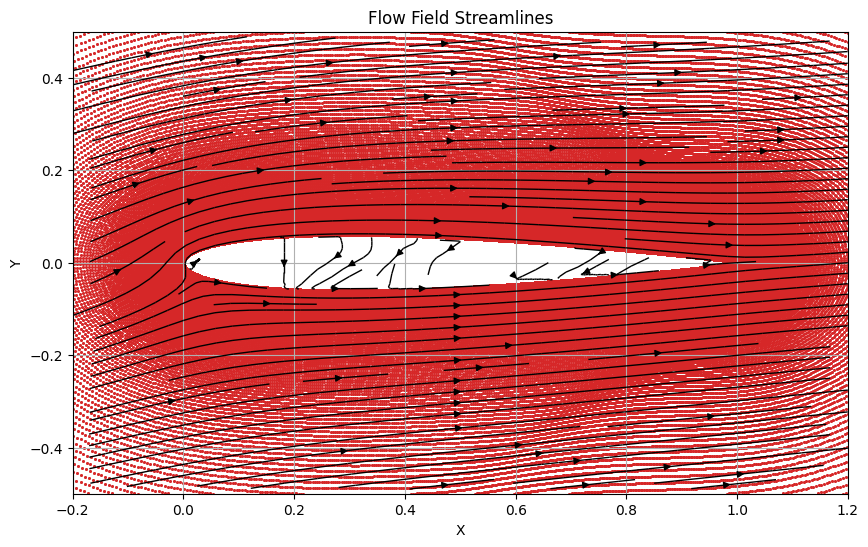

In [ ]:
flow_field_pod_view.generate_streamlines(x_range=x_range, y_range=y_range)